# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y = True)

1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



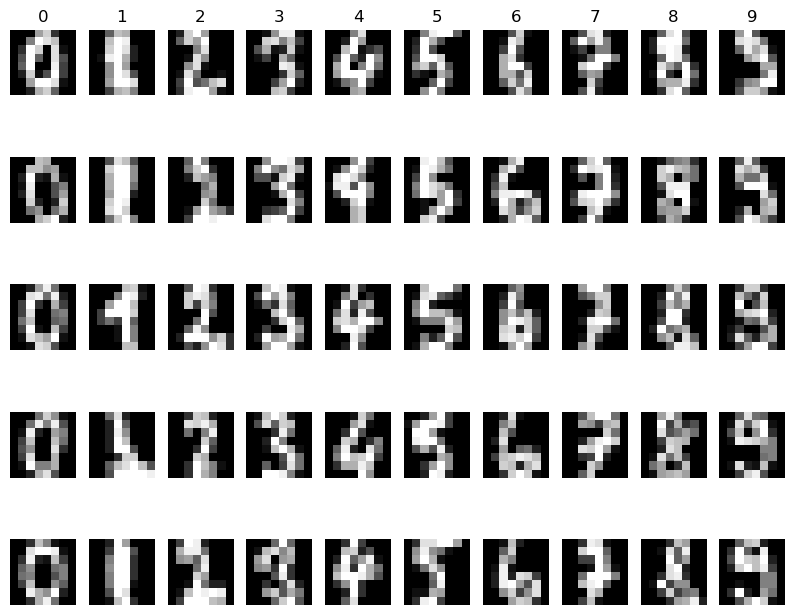

In [3]:
n_classes = np.unique(y).shape[0]
n_samples = 5

for class_index in np.unique(y):
    class_indexes = np.random.choice(np.flatnonzero(y == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(X[idx].reshape(8,8).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_index)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [4]:
from sklearn.model_selection import train_test_split
from time import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = int(time()))
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (1437, 64)
Training labels shape:  (1437,)
Test data shape:  (360, 64)
Test labels shape:  (360,)


Датасет MNIST по умолчанию предоставляет изображения в виде одномерного массива.

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [5]:
from scripts.classifiers import KNearestNeighbor

knn = KNearestNeighbor()
knn.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [6]:
knn_dists = knn.compute_distances_two_loops(X_test)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


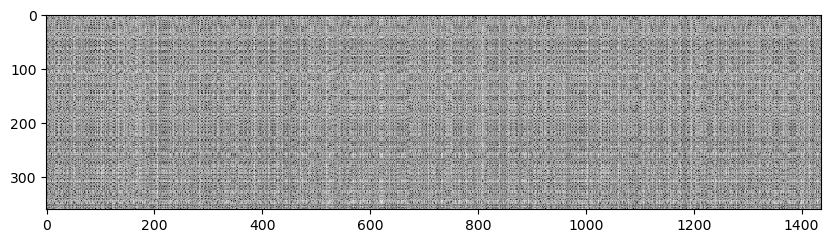

In [7]:
plt.imshow(knn_dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [8]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict_labels(knn_dists)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.9888888888888889


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [9]:
k_list = range(1, 21)
accuracy_list = [accuracy_score(y_test, knn.predict(X_test, k=k, num_loops=2)) for k in k_list]

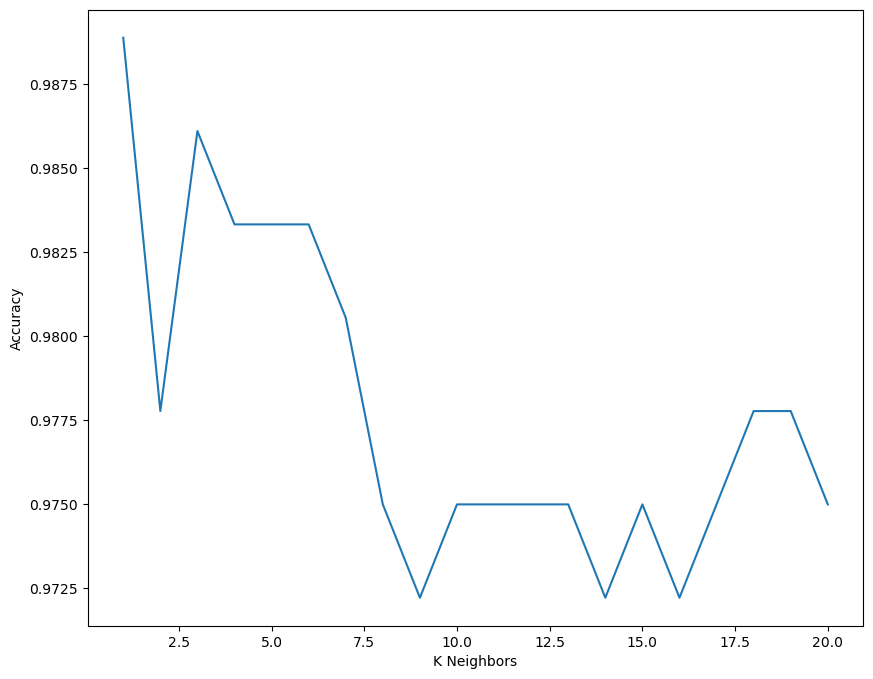

In [10]:
plt.plot(k_list, accuracy_list)
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [13]:
def cv_score(estimator, X, y, k_folds = 5, scoring = accuracy_score, 
             estimator_params = None, train_estimator_params = None, prediction_estimator_params = None, verbose = 1):
    y_folds = np.array_split(y, k_folds)
    X_folds = np.array_split(X, k_folds)

    accuracies = np.zeros((len(y_folds),))

    if verbose > 1:
        print(40 * "=")
        print(f"Cross validation for {estimator.__name__}")
        print(40 * "=")
    for fold in range(len(y_folds)):
        if verbose > 1:
            print(40 * "=")
            print(f"Fold: {fold}")

        y_train_fold = y_folds
        X_train_fold = X_folds

        y_test_fold = y_train_fold[fold]
        X_test_fold = X_train_fold[fold]

        X_train_elements = []
        y_train_elements = []

        for i, element in enumerate(zip(X_folds, y_folds)):
            if i != fold:
                X_train_elements.append(element[0])
                y_train_elements.append(element[1])

        y_train_fold = np.hstack(y_train_elements)
        X_train_fold = np.vstack(X_train_elements)

        if estimator_params:
            estimator_ = estimator(**estimator_params)
        else:
            estimator_ = estimator()

        if train_estimator_params:
            estimator_.train(X_train_fold, y_train_fold, **train_estimator_params)
        else:
            estimator_.train(X_train_fold, y_train_fold)

        if prediction_estimator_params:
            fold_y_pred = estimator_.predict(X_test_fold, **prediction_estimator_params)
        else:
            fold_y_pred = estimator_.predict(X_test_fold)

        if verbose > 1:
            print(f"Score: {scoring(y_test_fold, fold_y_pred)}")
            print(40 * "=")
        accuracies[fold] = scoring(y_test_fold, fold_y_pred)

    return accuracies

In [25]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from scripts.classifiers import KNearestNeighbor

k_possible = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100]
cross_val_results = []

for k in k_possible:
    score = cv_score(KNearestNeighbor, X_train, y_train, prediction_estimator_params={'k':k})
    cross_val_results.append({
        "k": k,
        "score": np.round(score, 3),
    })
    
cross_val_df = pd.DataFrame(data=cross_val_results)
cross_val_df["mean"] = cross_val_df["score"].apply(lambda x: np.mean(x))
cross_val_df["std"] = cross_val_df["score"].apply(lambda x: np.std(x))
cross_val_df

,k,score,mean,std
0,1,"[0.99, 0.99, 0.993, 0.983, 0.99]",0.9892,0.003311
1,2,"[0.99, 0.99, 0.983, 0.972, 0.983]",0.9836,0.006591
2,3,"[0.997, 0.99, 0.993, 0.972, 0.99]",0.9884,0.008593
3,4,"[0.997, 0.99, 0.993, 0.976, 0.976]",0.9864,0.008777
4,5,"[0.997, 0.997, 0.99, 0.972, 0.979]",0.9870,0.009980
5,10,"[1.0, 0.972, 0.99, 0.955, 0.979]",0.9792,0.015406
6,20,"[0.976, 0.976, 0.986, 0.941, 0.962]",0.9682,0.015600
7,50,"[0.948, 0.938, 0.965, 0.906, 0.923]",0.9360,0.020288
8,75,"[0.934, 0.906, 0.948, 0.885, 0.906]",0.9158,0.022400
9,100,"[0.913, 0.892, 0.937, 0.871, 0.899]",0.9024,0.021978


In [31]:
best_k = cross_val_df.sort_values(by="mean").sort_values(by="std", ascending=False).iloc[0]['k']
best_k

,k,score,mean,std
8,75,"[0.934, 0.906, 0.948, 0.885, 0.906]",0.9158,0.022400
9,100,"[0.913, 0.892, 0.937, 0.871, 0.899]",0.9024,0.021978
7,50,"[0.948, 0.938, 0.965, 0.906, 0.923]",0.9360,0.020288
6,20,"[0.976, 0.976, 0.986, 0.941, 0.962]",0.9682,0.015600
5,10,"[1.0, 0.972, 0.99, 0.955, 0.979]",0.9792,0.015406
4,5,"[0.997, 0.997, 0.99, 0.972, 0.979]",0.9870,0.009980
3,4,"[0.997, 0.99, 0.993, 0.976, 0.976]",0.9864,0.008777
2,3,"[0.997, 0.99, 0.993, 0.972, 0.99]",0.9884,0.008593
1,2,"[0.99, 0.99, 0.983, 0.972, 0.983]",0.9836,0.006591
0,1,"[0.99, 0.99, 0.993, 0.983, 0.99]",0.9892,0.003311



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [30]:
knn = KNearestNeighbor()
knn.train(X_train, y_train)
for i in range(3):
    print(f"Num loops: {i}, accuracy = {accuracy_score(y_test, knn.predict(X_test, k=best_k, num_loops=i))}")

Num loops: 0, accuracy = 0.9444444444444444
Num loops: 1, accuracy = 0.9444444444444444
Num loops: 2, accuracy = 0.9444444444444444


1.11 Сделайте выводы по результатам 1 части задания.

1. Метод k-ближайших соседей показывает высокую точность для выбранного набора данных.
2. Точность метода k-ближайших соседей зависит от выбора k. Чем больше k, тем точнее будет модель. Если взять слишком большое k, то модель переобучится и точность уменьшится.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [ ]:

from scripts.classifiers.linear_svm import svm_loss_naive
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))


2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

2.9 Сделайте выводы по второй части задания

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = int(time()))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = int(time()))
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (1149, 64)
Training labels shape:  (1149,)
Validation data shape:  (288, 64)
Validation labels shape:  (288,)
Test data shape:  (360, 64)
Test labels shape:  (360,)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[0.00000000e+00 3.08093995e-01 5.20278503e+00 1.18433420e+01
 1.20304613e+01 5.85378590e+00 1.34116623e+00 1.27937337e-01
 6.96257615e-03 1.95474326e+00]


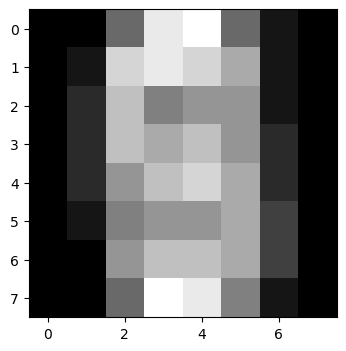

(1149, 65) (288, 65) (360, 65)


In [35]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((8,8)).astype('uint8')) 
plt.show()

X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [38]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(65, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302977
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [40]:
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: softmax_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.207341 analytic: 0.207341, relative error: 3.220627e-10
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.716229 analytic: -0.716229, relative error: 6.655363e-11
numerical: 0.121918 analytic: 0.121918, relative error: 3.594040e-10
numerical: -0.105613 analytic: -0.105613, relative error: 1.854962e-10
numerical: 0.119836 analytic: 0.119836, relative error: 5.623730e-10


C:\Users\Vladislav\Desktop\DL\scripts\gradient_check.py:126: RuntimeWarning: invalid value encountered in double_scalars
  rel_error = (abs(grad_numerical - grad_analytic) /


numerical: -0.144439 analytic: -0.144439, relative error: 2.377031e-10
numerical: 0.006657 analytic: 0.006657, relative error: 5.681887e-09
numerical: 0.392473 analytic: 0.392473, relative error: 1.146041e-10
numerical: 0.194182 analytic: 0.194182, relative error: 2.355168e-10
numerical: 0.009830 analytic: 0.009830, relative error: 2.270137e-09
numerical: -0.154573 analytic: -0.154573, relative error: 6.437913e-10
numerical: 0.180275 analytic: 0.180275, relative error: 4.570139e-10
numerical: -0.000344 analytic: -0.000344, relative error: 6.166112e-08
numerical: -0.474779 analytic: -0.474779, relative error: 1.708200e-10
numerical: 0.127878 analytic: 0.127878, relative error: 1.616143e-10
numerical: -0.680363 analytic: -0.680363, relative error: 2.722003e-10
numerical: -0.629066 analytic: -0.629066, relative error: 1.426701e-10
numerical: 0.220658 analytic: 0.220658, relative error: 5.530403e-10
numerical: 0.074145 analytic: 0.074145, relative error: 4.214258e-09


3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [41]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302977e+00 computed in 0.061055s
vectorized loss: 2.302977e+00 computed in 0.001002s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [44]:
from scripts.classifiers.linear_classifier import Softmax

softmax_classifier = Softmax()
softmax_classifier.train(X_train, y_train)
print(f"Accuracy: {accuracy_score(y_test, softmax_classifier.predict(X_test))}")

Accuracy: 0.8777777777777778


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [46]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

data = []
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        score = cv_score(
            Softmax,
            X_train,
            y_train,
            train_estimator_params=dict(learning_rate=learning_rate, reg=regularization_strength),
        )
        data.append({
            "learning_rate": learning_rate,
            "regularization_strength": regularization_strength,
            "score": score,
            "mean": np.mean(score),
            "std": np.std(score),
        })

C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:84: RuntimeWarning: overflow encountered in exp
  sum_j = np.sum(np.exp(scores), axis=1).reshape((num_train, 1))
C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:91: RuntimeWarning: overflow encountered in exp
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:91: RuntimeWarning: invalid value encountered in true_divide
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:84: RuntimeWarning: overflow encountered in exp
  sum_j = np.sum(np.exp(scores), axis=1).reshape((num_train, 1))
C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:91: RuntimeWarning: overflow encountered in exp
  dW = X.T.dot(np.exp(scores) / sum_j) - X.T.dot(correct_matrix)
C:\Users\Vladislav\Desktop\DL\scripts\classifiers\softmax.py:91: RuntimeWarning: invalid value encountered in true_di

In [48]:
softmax_cross_val_scores_df = pd.DataFrame(data=data)
softmax_cross_val_scores_df.sort_values(by="mean").sort_values(by="std", ascending=False)

,learning_rate,regularization_strength,score,mean,std
2,5.000000e-05,25000.0,"[0.7869565217391304, 0.7478260869565218, 0.804...",0.751004,0.051881
1,1.000000e-07,50000.0,"[0.17391304347826086, 0.11304347826086956, 0.0...",0.112299,0.043343
3,5.000000e-05,50000.0,"[0.07391304347826087, 0.0782608695652174, 0.12...",0.105309,0.027551
0,1.000000e-07,25000.0,"[0.1565217391304348, 0.10869565217391304, 0.10...",0.118348,0.020390


In [50]:
best_softmax_classifier = Softmax()
best_softmax_classifier.train(X_train, y_train, learning_rate=5e-5, reg=2.5e4)
print(f"Accuracy: {accuracy_score(y_test, best_softmax_classifier.predict(X_test))}")

Accuracy: 0.7833333333333333


3.10 Сделайте выводы по третьей части задания

На наборе данных MNIST классификатор kNN показывает себя точнее Softmax.